## PTA w/ 2D SFS

The new PTA 2D jMSFS and all 2D simulation code are in the PTA repo on a seperate branch `PTA-2D`.
```
git clone https://github.com/isaacovercast/PTA
cd PTA
git fetch --all
git checkout PTA-2D
pip install -e .
```

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import math
import msprime
import numpy as np
import pandas as pd
import PTA

pd.set_option('display.max_columns', None)

from IPython.display import SVG, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sim = PTA.DemographicModel("2D-test")
print(sim.get_params())

------- PTA params file (v.0.0.11)----------------------------------------------
2D-test              ## [0] [simulation_name]: The name of this simulation scenario
./default_PTA        ## [1] [project_dir]: Where to save files
10                   ## [2] [npops]: Number of populations undergoing co-demographic processes
4                    ## [3] [nsamps]: Numbers of samples for each populations
10000                ## [4] [N_e]: Effective population size of the contemporary population
20000                ## [5] [tau]: Time of demographic change
10                   ## [6] [epsilon]: Magnitude of demographic change
0                    ## [7] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
1000                 ## [8] [length]: Length in bp of each independent genomic region to simulate
100                  ## [9] [num_replicates]: Number of genomic regions to simulate
1                    ## [10] [generation_time]: Generation time in years
1e-09                #

## Modify some parameters

In [6]:
sim.set_param("npops", 4)                       # Number of co-distributed population pairs
sim.set_param("nsamps", [3,2])                  # Historical and contemporary sample size (in diploid individuals)
sim.set_param("num_replicates", 10)             # Number of independent genomic regions to simulate (# loci)
sim.set_param("muts_per_gen", 0.0000001)        # Obvious
sim.set_param("generation_time", 3)            # Obvious

## Run one 2d simulation to capture the results

In [13]:
my_jmsfs = sim.serial_simulate_2d(nsims=1)[0]

  [####################] 100%  Finished 1 simulations in   0:00:00 | 
 

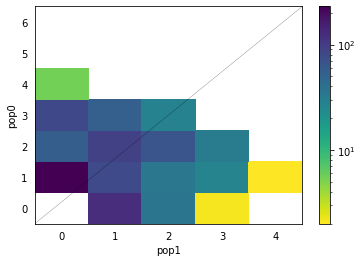

In [14]:
my_jmsfs.plot_2d_sfs()

## Run several simulations

In [15]:
sim.simulate(nsims=10)

    Generating 10 simulation(s).
  [####################] 100%  Finished 10 simulations in   0:00:00| 
 

## Simulation results are written to a file

In [25]:
!head -n 2 ./default_PTA/2D-test-SIMOUT.csv

zeta zeta_e psi t_s omega taus_mean taus_std taus_skewness taus_kurtosis taus_median taus_iqr epsilons_mean epsilons_std epsilons_skewness epsilons_kurtosis epsilons_median epsilons_iqr Ne_s_mean Ne_s_std Ne_s_skewness Ne_s_kurtosis Ne_s_median Ne_s_iqr 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
1 4 1 6666.667 0 6666.667 0.000 0.000 -3.000 6666.667 0.000 10.000 0.000 0.000 -3.000 10.000 0.000 10000.000 0.000 0.000 -3.000 10000.000 0.000 0.000 201.000 182.500 0.500 0.000 274.500 174.500 103.000 100.500 0.500 169.500 269.500 140.500 30.500 0.000 74.500 80.000 51.000 0.000 0.000 37.000 0.0

## They can also be loaded back in and reformatted nicely for analysis

In [26]:
params, jmsfs = sim.load_simulations()

In [27]:
print(params.[0], jmsfs[0])

KeyError: 0